In [2]:
import pickle
import sys
from zoneinfo import ZoneInfo
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import contextily as cx
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
px.set_mapbox_access_token(os.environ["MAPBOX_TOKEN"])
import plotly.express as px
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
import torch
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory
from openbustools.drivecycle.physics import conditions, energy, vehicle

In [3]:
if torch.cuda.is_available():
    num_workers=4
    pin_memory=True
    accelerator="cuda"
else:
    num_workers=0
    pin_memory=False
    accelerator="cpu"

logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)

model = model_utils.load_model("../logs/saved_models/", "kcm_1month_resampled", "GRU", 0)
model.eval()

GRU(
  (loss_fn): MSELoss()
  (min_em): MinuteEmbedding(
    (em): Embedding(1440, 48)
  )
  (day_em): DayEmbedding(
    (em): Embedding(7, 4)
  )
  (rnn): GRU(4, 64, num_layers=2, dropout=0.05)
  (feature_extract): Linear(in_features=116, out_features=1, bias=True)
  (feature_extract_activation): ReLU()
)

In [4]:
train_data_folders = [f"../data/kcm_realtime/processed/"]
test_dates = ['2023_04_15.pkl']
train_dates = standardfeeds.get_date_list('2023_04_15', 1)

test_data, holdout_routes, test_config = data_loader.load_h5(train_data_folders, test_dates, only_holdout=True, holdout_routes=model.holdout_routes, config=model.config)
test_dataset = data_loader.H5Dataset(test_data)
test_dataset.include_grid = model.include_grid

### Inference on Holdout Routes

In [5]:
gtfs = standardfeeds.get_gtfs_shapes_lookup("../data/kcm_gtfs/2023_01_23/")
gtfs_shapes = standardfeeds.get_gtfs_shapes("../data/kcm_gtfs/2023_01_23/", epsg=32148)

In [6]:
# Read the pickle files, splitting holdout and non-holdout samples
res = {}
all_holdout_shingles = []
all_other_shingles = []
for day in train_dates:
    shingles = pd.read_pickle(Path('..', 'data', 'kcm_realtime', 'processed', '2023_04_15.pkl'))
    holdout_shingles = shingles[shingles['route_id'].isin(model.holdout_routes)]
    other_shingles = shingles[~shingles['route_id'].isin(model.holdout_routes)]
    all_holdout_shingles.append(holdout_shingles)
    all_other_shingles.append(other_shingles)
all_holdout_shingles = pd.concat(all_holdout_shingles)
all_other_shingles = pd.concat(all_other_shingles)

print(pd.unique(all_holdout_shingles['route_id']))
print([x in pd.unique(all_other_shingles['route_id']) for x in pd.unique(all_holdout_shingles['route_id'])])
print(pd.unique(all_other_shingles['route_id']))
holdout_routes_in_data = pd.unique(all_holdout_shingles['route_id'])

['100229' '102719' '102736']
[False, False, False]
['102548' '100099' '100133' '100136' '102703' '102704' '100023' '100132'
 '100194' '100161' '100169' '100030' '100024' '100249' '100005' '100009'
 '100512' '102619' '102581' '100018' '100042' '102554' '100060' '100489'
 '100254' '100259' '100193' '100214' '100269' '100225' '100139' '100028'
 '100089' '100006' '100045' '100003' '102720' '100202' '100196' '100204'
 '100205' '100267' '102574' '102615' '100146' '100031' '100252' '102730'
 '100026' '100004' '100074' '100016' '102717' '100224' '100210' '100039'
 '100264' '100002' '100263' '100001' '100219' '100223' '100447' '100228'
 '100113' '102552' '100275' '102701' '102705' '102702' '100203' '100162'
 '100101' '100230' '100173' '102576' '100184']


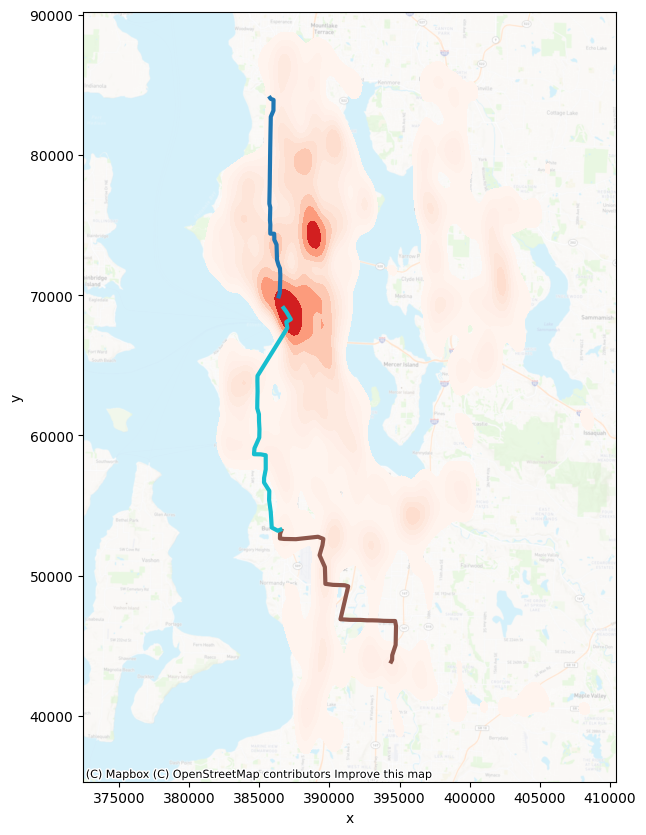

In [7]:
# Plot the holdout shapes over heatmap of all other shingles
df = all_other_shingles.sample(10000)
holdout_shapes = gtfs_shapes[gtfs_shapes['route_id'].isin(holdout_routes_in_data)].groupby('route_id').nth(0)

fig, axes = plt.subplots(1, 1, figsize=(10,10))
sns.kdeplot(ax=axes, x=df.x, y=df.y, cmap="Reds", fill=True, bw_adjust=.4)
holdout_shapes.plot(ax=axes, column='route_id', linewidth=3)
cx.add_basemap(ax=axes, crs=holdout_shapes.crs.to_string(), alpha=0.3, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))
plt.show()

In [8]:
# Make predictions for the holdout route shingles
res = {}
test_loader = DataLoader(
    test_dataset,
    collate_fn=model.collate_fn,
    batch_size=model.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)
trainer = pl.Trainer(
    accelerator=accelerator,
    logger=False,
    inference_mode=True,
    enable_progress_bar=False,
    enable_model_summary=False,
)
preds_and_labels = trainer.predict(model=model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
# Extract raw predictions and labels from the output
all_preds = np.concatenate([x['preds_raw'][x['mask']] for x in preds_and_labels])
all_labels = np.concatenate([x['labels_raw'][x['mask']] for x in preds_and_labels])

# Extract the input features from the dataset
shingles = []
for i in range(len(test_data)):
    shingle = test_data[i]['feats_n'][1:]
    shingles.append(shingle)
shingles = np.concatenate(shingles)

# Combine into analysis dataframe
df = pd.DataFrame(shingles, columns=data_loader.NUM_FEAT_COLS)
df['preds'] = all_preds
df['labels'] = all_labels
df['MAPE'] = np.abs(df['preds'] - df['labels']) / df['labels']
df['RMSE'] = np.sqrt((df['preds'] - df['labels']) ** 2)
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:32148")

# Reproject to WGS84
reproj = df.to_crs("EPSG:4326")
reproj['lon'] = reproj.geometry.x
reproj['lat'] = reproj.geometry.y
reproj = reproj[reproj['MAPE'] < 5]

In [28]:
fig = ff.create_hexbin_mapbox(
    data_frame=reproj, lat="lat", lon="lon", width=500,
    height=700,
    nx_hexagon=15, opacity=0.9, labels={"color": "Average MAPE"},
    color="MAPE", agg_func=np.mean, color_continuous_scale="Icefire", range_color=[.3,.5]
)
fig.show()

In [25]:
fig = ff.create_hexbin_mapbox(
    data_frame=reproj, lat="lat", lon="lon", width=500,
    height=700,
    nx_hexagon=20, opacity=0.9, labels={"color": "Std. Dev. Speed (m/s)"},
    color="calc_speed_m_s", agg_func=np.std, color_continuous_scale="Icefire", range_color=[0,5]
)
fig.show()

In [18]:
# # Plot model accuracy over the holdout route
# fig = px.density_mapbox(
#     reproj,
#     width=500,
#     height=700,
#     lat='lat',
#     lon='lon',
#     z='MAPE',
#     radius=10,
#     zoom=9,
#     mapbox_style="open-street-map",
#     color_continuous_scale='rainbow')
# fig.show()

In [ ]:
plot_df = df[df['MAPE']<1].copy()
fig, axes = plt.subplots(1, 1, figsize=(10,10))
plt.hexbin(plot_df.x, plot_df.y, plot_df.MAPE, cmap='plasma', gridsize=15)
# sns.kdeplot(ax=axes, x=plot_df.x, y=plot_df.y, weights=plot_df.MAPE, cmap="plasma", fill=True, bw_adjust=.2)
# cx.add_basemap(ax=axes, crs=plot_df.crs.to_string(), alpha=0.3, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))
plt.show()

In [ ]:
# Set up model
atb_base_model_list, atb_nn_model = model_utils.make_one_model(model_type, hyperparameter_dict=hyperparameter_dict, embed_dict=embed_dict, config=atb_config, skip_gtfs=skip_gtfs, load_weights=True, weight_folder=f"{run_folder}{kcm_network_folder}models/{model_type}/logs/{model_type}/version_{fold_num}/checkpoints/", fold_num=4)
print(f"Evaluating: {atb_nn_model.model_name}")
# Set up dataset
atb_dataset = data_loader.LoadSliceDataset(f"{run_folder}{atb_network_folder}deeptte_formatted/test", atb_config, skip_gtfs=skip_gtfs)
atb_ngrid = grids.NGridBetter(atb_config['grid_bounds'][0], grid_s_size)
atb_ngrid.add_grid_content(atb_dataset.get_all_samples(keep_cols=['shingle_id','locationtime','x','y','speed_m_s','bearing']), trace_format=True)
atb_ngrid.build_cell_lookup()
atb_dataset.grid = atb_ngrid
atb_dataset.add_grid_features = atb_nn_model.requires_grid
loader = DataLoader(atb_dataset, sampler=SequentialSampler(atb_dataset), collate_fn=atb_nn_model.collate_fn, batch_size=atb_nn_model.batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False)
trainer = pl.Trainer(
    accelerator="cpu",
    logger=False
)
preds_and_labels = trainer.predict(model=atb_nn_model, dataloaders=loader)

# Extract predictions
atb_preds = np.concatenate([x['out'][x['mask']] for x in preds_and_labels])
atb_labels = np.concatenate([x['y'][x['mask']] for x in preds_and_labels])
# Extract data points and connect to predictions
atb_data = [x for x in atb_dataset]
atb_feats = np.concatenate([x['samp'] for x in atb_data])
atb_ys = np.array([x['norm_label'] for x in atb_data])
atb_res = pd.DataFrame(atb_feats, columns=atb_dataset.col_names)
atb_res['preds'] = atb_preds
atb_res['labels'] = atb_labels
# Get geometries and other features for every prediciton point
atb_res['pred_speeds'] = atb_res['dist_calc_km']*1000 / atb_res['preds']
atb_res['label_speeds'] = atb_res['dist_calc_km']*1000 / atb_res['labels']
atb_res['absolute_error'] = abs(atb_res['preds'] - atb_res['labels'])
atb_res['hour'] = atb_res['timeID']//60
points = gpd.points_from_xy(atb_res['lon'], atb_res['lat'], crs="EPSG:4326")
atb_res = gpd.GeoDataFrame(atb_res, geometry=points)
atb_res = atb_res.sample(100000)
# Overall accuracy on data points
print(f"MAE: {metrics.mean_absolute_error(atb_labels,atb_preds)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(atb_labels,atb_preds)}")
atb_res

In [ ]:
# Set up model
kcm_base_model_list, kcm_nn_model = model_utils.make_one_model(model_type, hyperparameter_dict=hyperparameter_dict, embed_dict=embed_dict, config=kcm_config, skip_gtfs=skip_gtfs, load_weights=True, weight_folder=f"{run_folder}{kcm_network_folder}models/{model_type}/logs/{model_type}/version_{fold_num}/checkpoints/", fold_num=4)
print(f"Evaluating: {kcm_nn_model.model_name}")
# Set up dataset
kcm_dataset = data_loader.LoadSliceDataset(f"{run_folder}{kcm_network_folder}deeptte_formatted/test", kcm_config, skip_gtfs=skip_gtfs)
kcm_ngrid = grids.NGridBetter(kcm_config['grid_bounds'][0], grid_s_size)
kcm_ngrid.add_grid_content(atb_dataset.get_all_samples(keep_cols=['shingle_id','locationtime','x','y','speed_m_s','bearing']), trace_format=True)
kcm_ngrid.build_cell_lookup()
kcm_dataset.grid = kcm_ngrid
kcm_dataset.add_grid_features = kcm_nn_model.requires_grid
loader = DataLoader(kcm_dataset, sampler=SequentialSampler(kcm_dataset), collate_fn=kcm_nn_model.collate_fn, batch_size=kcm_nn_model.batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False)
trainer = pl.Trainer(
    accelerator="cpu",
    logger=False
)
preds_and_labels = trainer.predict(model=kcm_nn_model, dataloaders=loader)

# Extract predictions
kcm_preds = np.concatenate([x['out'][x['mask']] for x in preds_and_labels])
kcm_labels = np.concatenate([x['y'][x['mask']] for x in preds_and_labels])
# Extract data points and connect to predictions
kcm_data = [x for x in kcm_dataset]
kcm_feats = np.concatenate([x['samp'] for x in kcm_data])
kcm_ys = np.array([x['norm_label'] for x in kcm_data])
kcm_res = pd.DataFrame(kcm_feats, columns=kcm_dataset.col_names)
kcm_res['preds'] = kcm_preds
kcm_res['labels'] = kcm_labels
# Get geometries and other features for every prediciton point
kcm_res['pred_speeds'] = kcm_res['dist_calc_km']*1000 / kcm_res['preds']
kcm_res['label_speeds'] = kcm_res['dist_calc_km']*1000 / kcm_res['labels']
kcm_res['absolute_error'] = abs(kcm_res['preds'] - kcm_res['labels'])
kcm_res['hour'] = kcm_res['timeID']//60
points = gpd.points_from_xy(kcm_res['lon'], kcm_res['lat'], crs="EPSG:4326")
kcm_res = gpd.GeoDataFrame(kcm_res, geometry=points)
kcm_res = kcm_res.sample(100000)
# Overall accuracy on data points
print(f"MAE: {metrics.mean_absolute_error(kcm_labels,kcm_preds)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(kcm_labels,kcm_preds)}")
kcm_res

In [ ]:
# axes = geoplot.pointplot(atb_res, projection=geoplot.crs.AlbersEqualArea(), s=0.1)
# geoplot.kdeplot(atb_res, fill=True, cmap='coolwarm', alpha=0.5, bw_adjust=0.5, ax=axes)
# axes.set_title(f"Point Heatmap(atb)")
# plt.savefig("../plots/model_spatial_performance_atb.png", dpi=600, bbox_inches='tight')

# axes = geoplot.pointplot(kcm_res, projection=geoplot.crs.AlbersEqualArea(), s=0.1)
# geoplot.kdeplot(kcm_res, fill=True, cmap='coolwarm', alpha=0.5, bw_adjust=0.5, ax=axes)
# axes.set_title(f"Point Heatmap (KCM)")
# plt.savefig("../plots/model_spatial_performance_kcm.png", dpi=600, bbox_inches='tight')

In [ ]:
fig = ff.create_hexbin_mapbox(
    data_frame=kcm_res,
    lat="lat",
    lon="lon",
    nx_hexagon=30,
    opacity=0.7,
    labels={"color": "SD of Speed Predictions (m/s)"},
    color="pred_speeds",
    agg_func=np.std,
    color_continuous_scale="Icefire",
    range_color=[0,10]
)
fig.show()
fig.write_image(f"../plots/within_sd_preds_hexbin_kcm.eps")
fig.write_image(f"../plots/within_sd_preds_hexbin_kcm.png")

fig = ff.create_hexbin_mapbox(
    data_frame=kcm_res,
    lat="lat",
    lon="lon",
    nx_hexagon=30,
    opacity=0.7,
    labels={"color": "SD of Speed Labels (m/s)"},
    color="label_speeds",
    agg_func=np.std,
    color_continuous_scale="Icefire",
    range_color=[0,10]
)
fig.show()
fig.write_image(f"../plots/within_sd_labels_hexbin_kcm.eps")
fig.write_image(f"../plots/within_sd_labels_hexbin_kcm.png")

In [ ]:
fig = ff.create_hexbin_mapbox(
    data_frame=atb_res,
    lat="lat",
    lon="lon",
    nx_hexagon=30,
    opacity=0.7,
    labels={"color": "SD of Speed Predictions (m/s)"},
    color="pred_speeds",
    agg_func=np.std,
    color_continuous_scale="Icefire",
    range_color=[0,10]
)
fig.show()
fig.write_image(f"../plots/within_sd_preds_hexbin_atb.eps")
fig.write_image(f"../plots/within_sd_preds_hexbin_atb.png")

fig = ff.create_hexbin_mapbox(
    data_frame=atb_res,
    lat="lat",
    lon="lon",
    nx_hexagon=30,
    opacity=0.7,
    labels={"color": "SD of Speed Labels (m/s)"},
    color="label_speeds",
    agg_func=np.std,
    color_continuous_scale="Icefire",
    range_color=[0,10]
)
fig.show()
fig.write_image(f"../plots/within_sd_labels_hexbin_atb.eps")
fig.write_image(f"../plots/within_sd_labels_hexbin_atb.png")

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(6,8))
fig.tight_layout()
axes = axes.flatten()
sns.histplot(kcm_res, x="pred_speeds", ax=axes[0])
axes[0].set_title(f"KCM Prediction Metrics")
axes[0].set_xlabel("Predicted Speed (m/s)")
axes[0].set_xlim(0,30)
sns.histplot(atb_res, x="pred_speeds", ax=axes[1])
axes[1].set_title(f"AtB Prediction Metrics")
axes[1].set_xlabel("Predicted Speed (m/s)")
axes[1].set_xlim(0,30)
sns.histplot(kcm_res, x="label_speeds", ax=axes[2])
axes[2].set_xlabel("Label Speed (m/s)")
axes[2].set_xlim(0,30)
sns.histplot(atb_res, x="label_speeds", ax=axes[3])
axes[3].set_xlabel("Label Speed (m/s)")
axes[3].set_xlim(0,30)
sns.histplot(kcm_res, x="absolute_error", ax=axes[4])
axes[4].set_xlabel("Absolute Error (s)")
axes[4].set_xlim(0,30)
sns.histplot(atb_res, x="absolute_error", ax=axes[5])
axes[5].set_xlabel("Absolute Error (s)")
axes[5].set_xlim(0,30)
plt.savefig("../plots/model_prediction_distribution_comparison.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_prediction_distribution_comparison.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(6,8))
fig.tight_layout()
axes = axes.flatten()
sns.lineplot(kcm_res, x="hour", y="pred_speeds", ax=axes[0])
axes[0].set_title(f"KCM Prediction Metrics")
axes[0].set_xlabel("Hour of Day")
axes[0].set_xlim(0,24)
sns.lineplot(atb_res, x="hour", y="pred_speeds", ax=axes[1])
axes[1].set_title(f"AtB Prediction Metrics")
axes[1].set_xlabel("Hour of Day")
axes[1].set_xlim(0,24)
sns.lineplot(kcm_res, x="hour", y="label_speeds", ax=axes[2])
axes[2].set_xlabel("Hour of Day")
axes[2].set_xlim(0,24)
sns.lineplot(atb_res, x="hour", y="label_speeds", ax=axes[3])
axes[3].set_xlabel("Hour of Day")
axes[3].set_xlim(0,24)
sns.lineplot(kcm_res, x="hour", y="absolute_error", ax=axes[4])
axes[4].set_xlabel("Hour of Day")
axes[4].set_xlim(0,24)
sns.lineplot(atb_res, x="hour", y="absolute_error", ax=axes[5])
axes[5].set_xlabel("Hour of Day")
axes[5].set_xlim(0,24)
plt.savefig("../plots/model_hourly_comparison.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_hourly_comparison.png", format='png', dpi=600, bbox_inches='tight')

### Inference on Entire Network

In [ ]:
# Create grid of regularly spaced fake shingles to feed model
inference_shingles = data_utils.create_grid_of_shingles(100, atb_config['grid_bounds'][0], atb_config['coord_ref_center'][0])

# Make predictions for the fake shingles
atb_dataset = data_loader.ContentDataset(inference_shingles, atb_config, skip_gtfs=True)
loader = DataLoader(atb_dataset, sampler=SequentialSampler(atb_dataset), collate_fn=atb_nn_model.collate_fn, batch_size=atb_nn_model.batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False)
trainer = pl.Trainer(
    accelerator="cpu",
    logger=False
)
preds_and_labels = trainer.predict(model=atb_nn_model, dataloaders=loader)
atb_preds = np.concatenate([x['out'][x['mask']] for x in preds_and_labels])
atb_labels = np.concatenate([x['y'][x['mask']] for x in preds_and_labels])

# Extract predictions
atb_preds = np.concatenate([x['out'][x['mask']] for x in preds_and_labels])
atb_labels = np.concatenate([x['y'][x['mask']] for x in preds_and_labels])
# Extract data points and connect to predictions
atb_data = [x for x in atb_dataset]
atb_feats = np.concatenate([x['samp'] for x in atb_data])
atb_ys = np.array([x['norm_label'] for x in atb_data])
atb_res = pd.DataFrame(atb_feats, columns=atb_dataset.col_names)
atb_res['preds'] = atb_preds
atb_res['labels'] = atb_labels
# Get geometries and other features for every prediciton point
atb_res['pred_speeds'] = atb_res['dist_calc_km']*1000 / atb_res['preds']
atb_res['label_speeds'] = atb_res['dist_calc_km']*1000 / atb_res['labels']
atb_res['absolute_error'] = abs(atb_res['preds'] - atb_res['labels'])
atb_res['hour'] = atb_res['timeID']//60
points = gpd.points_from_xy(atb_res['lon'], atb_res['lat'], crs="EPSG:4326")
atb_res = gpd.GeoDataFrame(atb_res, geometry=points)
# Transform x and y to replace dummy lat and lon for mapping
transformer = pyproj.Transformer.from_crs(atb_crs, default_crs)
atb_res['lat'], atb_res['lon'] = transformer.transform(atb_res['x'], atb_res['y'])
points = gpd.points_from_xy(atb_res['lon'], atb_res['lat'], crs=default_crs)
atb_res = gpd.GeoDataFrame(atb_res, geometry=points)
atb_res

In [ ]:
# Create grid of regularly spaced fake shingles to feed model
inference_shingles = data_utils.create_grid_of_shingles(100, kcm_config['grid_bounds'][0], kcm_config['coord_ref_center'][0])

# Make predictions for the fake shingles
kcm_dataset = data_loader.ContentDataset(inference_shingles, kcm_config, skip_gtfs=True)
loader = DataLoader(kcm_dataset, sampler=SequentialSampler(kcm_dataset), collate_fn=kcm_nn_model.collate_fn, batch_size=kcm_nn_model.batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False)
trainer = pl.Trainer(
    accelerator="cpu",
    logger=False
)
preds_and_labels = trainer.predict(model=kcm_nn_model, dataloaders=loader)
kcm_preds = np.concatenate([x['out'][x['mask']] for x in preds_and_labels])
kcm_labels = np.concatenate([x['y'][x['mask']] for x in preds_and_labels])

# Extract predictions
kcm_preds = np.concatenate([x['out'][x['mask']] for x in preds_and_labels])
kcm_labels = np.concatenate([x['y'][x['mask']] for x in preds_and_labels])
# Extract data points and connect to predictions
kcm_data = [x for x in kcm_dataset]
kcm_feats = np.concatenate([x['samp'] for x in kcm_data])
kcm_ys = np.array([x['norm_label'] for x in kcm_data])
kcm_res = pd.DataFrame(kcm_feats, columns=kcm_dataset.col_names)
kcm_res['preds'] = kcm_preds
kcm_res['labels'] = kcm_labels
# Get geometries and other features for every prediciton point
kcm_res['pred_speeds'] = kcm_res['dist_calc_km']*1000 / kcm_res['preds']
kcm_res['label_speeds'] = kcm_res['dist_calc_km']*1000 / kcm_res['labels']
kcm_res['absolute_error'] = abs(kcm_res['preds'] - kcm_res['labels'])
kcm_res['hour'] = kcm_res['timeID']//60
points = gpd.points_from_xy(kcm_res['lon'], kcm_res['lat'], crs="EPSG:4326")
kcm_res = gpd.GeoDataFrame(kcm_res, geometry=points)
# Transform x and y to replace dummy lat and lon for mapping
transformer = pyproj.Transformer.from_crs(kcm_crs, default_crs)
kcm_res['lat'], kcm_res['lon'] = transformer.transform(kcm_res['x'], kcm_res['y'])
points = gpd.points_from_xy(kcm_res['lon'], kcm_res['lat'], crs=default_crs)
kcm_res = gpd.GeoDataFrame(kcm_res, geometry=points)
kcm_res

In [ ]:
fig = ff.create_hexbin_mapbox(
    data_frame=atb_res,
    lat="lat",
    lon="lon",
    nx_hexagon=50,
    opacity=0.7,
    labels={"color": "Mean Speed (m/s)"},
    color="pred_speeds",
    agg_func=np.mean,
    color_continuous_scale="Icefire_r",
)
fig.show()
fig.write_image(f"../plots/mesh_mean_pred_speeds_hexbin_atb.eps")
fig.write_image(f"../plots/mesh_mean_pred_speeds_hexbin_atb.png")

fig = ff.create_hexbin_mapbox(
    data_frame=kcm_res,
    lat="lat",
    lon="lon",
    nx_hexagon=50,
    opacity=0.7,
    labels={"color": "Mean Speed (m/s)"},
    color="pred_speeds",
    agg_func=np.mean,
    color_continuous_scale="Icefire_r",
)
fig.show()
fig.write_image(f"../plots/mesh_mean_pred_speeds_hexbin_kcm.eps")
fig.write_image(f"../plots/mesh_mean_pred_speeds_hexbin_kcm.png")